In [1]:
pip install deepxde

Note: you may need to restart the kernel to use updated packages.


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float32
Compiling model...
'compile' took 8.672589 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.39e+01, 4.39e+01, 2.31e+02, 1.00e+06, 2.72e+04, 2.16e+05]    [4.59e+01, 3.39e+01, 2.02e+02, 1.00e+06, 2.72e+04, 2.16e+05]    []  
500       [1.12e+00, 6.87e-01, 2.02e+00, 1.31e+00, 6.19e+00, 1.48e+00]    [9.34e-01, 2.54e-01, 1.09e+00, 1.31e+00, 6.19e+00, 1.48e+00]    []  
1000      [6.88e-01, 5.30e-01, 9.71e-01, 1.18e+00, 2.01e+00, 5.65e-01]    [5.91e-01, 2.42e-01, 5.56e-01, 1.18e+00, 2.01e+00, 5.65e-01]    []  
1500      [4.46e-01, 3.70e-01, 7.19e-01, 3.34e-02, 5.83e-01, 1.55e-01]    [3.46e-01, 1.54e-01, 4.49e-01, 3.34e-02, 5.83e-01, 1.55e-01]    []  
2000      [2.97e-01, 2.23e-01, 4.01e-01, 9.79e-01, 5.85e-01, 8.35e-02]    [1.84e-01, 1.11e-01, 1.90e-01, 9.79e-01, 5.85e-01, 8.35e-02]    []  
2500      [2.06e-01, 1.78e-01, 3

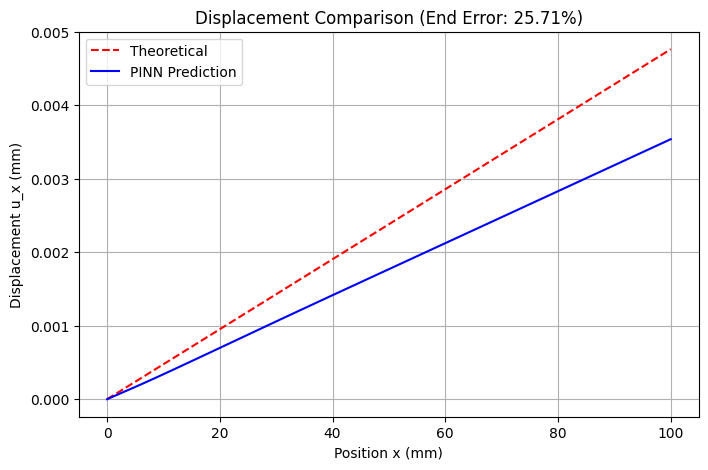

Theoretical Max Displacement: 0.004762 mm
Predicted Max Displacement:   0.003538 mm


In [2]:
import os
os.environ["DDE_BACKEND"] = "pytorch"

import torch
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

dde.config.set_default_float("float32")

# 1. パラメータ
LENGTH, WIDTH, HEIGHT = 100.0, 10.0, 10.0
E, nu = 210000.0, 0.3
mu = E / (2 * (1 + nu))
lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))
LOAD_FORCE = 1000.0
AREA = WIDTH * HEIGHT
TRACTION_X = LOAD_FORCE / AREA 

# スケーリング（学習を安定させるためNNの出力を100倍で扱う）
U_SCALE = 100.0 

# 2. 物理定義
def compute_stress(x, u):
    u_s = u / U_SCALE
    du = dde.grad.jacobian(u_s, x, i=0, j=0)
    dv = dde.grad.jacobian(u_s, x, i=1, j=1)
    dw = dde.grad.jacobian(u_s, x, i=2, j=2)
    du_y = dde.grad.jacobian(u_s, x, i=0, j=1)
    dv_x = dde.grad.jacobian(u_s, x, i=1, j=0)
    dv_z = dde.grad.jacobian(u_s, x, i=1, j=2)
    dw_y = dde.grad.jacobian(u_s, x, i=2, j=1)
    dw_x = dde.grad.jacobian(u_s, x, i=2, j=0)
    du_z = dde.grad.jacobian(u_s, x, i=0, j=2)

    eps_xx, eps_yy, eps_zz = du, dv, dw
    eps_xy, eps_yz, eps_zx = 0.5*(du_y+dv_x), 0.5*(dv_z+dw_y), 0.5*(dw_x+du_z)
    trace = eps_xx + eps_yy + eps_zz
    s_xx = lmbd * trace + 2 * mu * eps_xx
    s_yy = lmbd * trace + 2 * mu * eps_yy
    s_zz = lmbd * trace + 2 * mu * eps_zz
    s_xy, s_yz, s_zx = 2*mu*eps_xy, 2*mu*eps_yz, 2*mu*eps_zx
    return s_xx, s_yy, s_zz, s_xy, s_yz, s_zx

def pde(x, u):
    s_xx, s_yy, s_zz, s_xy, s_yz, s_zx = compute_stress(x, u)
    dg_x = dde.grad.jacobian(s_xx, x, i=0, j=0) + dde.grad.jacobian(s_xy, x, i=0, j=1) + dde.grad.jacobian(s_zx, x, i=0, j=2)
    dg_y = dde.grad.jacobian(s_xy, x, i=0, j=0) + dde.grad.jacobian(s_yy, x, i=0, j=1) + dde.grad.jacobian(s_yz, x, i=0, j=2)
    dg_z = dde.grad.jacobian(s_zx, x, i=0, j=0) + dde.grad.jacobian(s_yz, x, i=0, j=1) + dde.grad.jacobian(s_zz, x, i=0, j=2)
    return [dg_x, dg_y, dg_z]

# 3. 幾何・境界
geom = dde.geometry.Cuboid([0, 0, 0], [LENGTH, WIDTH, HEIGHT])
def boundary_loaded(x, on_boundary):
    return on_boundary and np.isclose(x[0], LENGTH)

def bc_stress_xx(x, y, X):
    s_xx, _, _, _, _, _ = compute_stress(x, y)
    return s_xx - TRACTION_X

def bc_stress_xy(x, y, X):
    _, _, _, s_xy, _, _ = compute_stress(x, y)
    return s_xy

def bc_stress_xz(x, y, X):
    _, _, _, _, _, s_zx = compute_stress(x, y)
    return s_zx

bcs = [
    dde.OperatorBC(geom, bc_stress_xx, boundary_loaded),
    dde.OperatorBC(geom, bc_stress_xy, boundary_loaded),
    dde.OperatorBC(geom, bc_stress_xz, boundary_loaded)
]

data = dde.data.PDE(geom, pde, bcs, num_domain=2000, num_boundary=400, num_test=500)
net = dde.nn.FNN([3] + [64] * 4 + [3], "tanh", "Glorot normal")
def output_transform(x, y):
    return (x[:, 0:1] / LENGTH) * y
net.apply_output_transform(output_transform)
model = dde.Model(data, net)

# 4. 学習（Adam 10000回 + L-BFGS）
dde.optimizers.config.set_LBFGS_options(maxiter=2000)

loss_weights = [1, 1, 1, 1000, 1000, 1000]
model.compile("adam", lr=1e-3, loss_weights=loss_weights)
model.train(iterations=10000, display_every=500) # Adamを長めに

model.compile("L-BFGS", loss_weights=loss_weights)
model.train(display_every=100)

# 5. 評価とグラフ表示
delta_theory = (LOAD_FORCE * LENGTH) / (AREA * E)

# x軸に沿ったサンプリング点を作成 (y=5, z=5 の中心線)
x_eval = np.linspace(0, LENGTH, 100).reshape(-1, 1)
y_eval = np.full_like(x_eval, WIDTH/2)
z_eval = np.full_like(x_eval, HEIGHT/2)
pts = np.hstack((x_eval, y_eval, z_eval))

# 推論
u_pred_all = model.predict(pts)
u_x_pred = u_pred_all[:, 0] / U_SCALE # スケール戻し

# 理論解
u_x_theory = (x_eval.flatten() / LENGTH) * delta_theory

# グラフ作成
plt.figure(figsize=(8, 5))
plt.plot(x_eval, u_x_theory, 'r--', label="Theoretical")
plt.plot(x_eval, u_x_pred, 'b-', label="PINN Prediction")
plt.xlabel("Position x (mm)")
plt.ylabel("Displacement u_x (mm)")
plt.title(f"Displacement Comparison (End Error: {abs(u_x_pred[-1]-delta_theory)/delta_theory*100:.2f}%)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Theoretical Max Displacement: {delta_theory:.6f} mm")
print(f"Predicted Max Displacement:   {u_x_pred[-1]:.6f} mm")